# BDSI Data Mining Group
# Example Data Build and EDA - 6/22/22

In [ ]:
library(tidyr)
library(dplyr)
library(stringr)
library(ggplot2)
library(repr)
library(maps)

# Change Jupyter plots size to 15x10 - much easier to see
options(repr.plot.width=15, repr.plot.height=10)

## Mortality Data

First, I will look at the mortality data that I downloaded from CDC WONDER.

In [ ]:
mort_raw <- read.delim("../raw-data/WONDER/mort_9920_state_year.txt")

In [ ]:
head(mort_raw)
summary(mort_raw)

The data has 8 variables, and it looks like the `Year` and `Year.Code` variables are the same. There is also a `Notes` column, that I don't think I need

The other thing I notice is that there are a lot of missing entries in the `Year` column, which seems weird, let's check it out.

In [ ]:
mort_raw %>%
    filter(is.na(Year))

When `Year` is missing, it is either a Total value across all years for a state, or there are a bunch of rows for just notes at the bottom. I don't want any of these rows to be included.

I will drop all of those rows and also only keep the columns that I need, renaming them to names that make sense to me. I personally don't like having capitilized column names.

In [ ]:
mort <- mort_raw %>%
    filter(!is.na(Year)) %>%
    select(stateName = State,
            stateFIPS = State.Code,
            year = Year,
            mort = Deaths,
            pop = Population)

In [ ]:
head(mort)

Now we have a nice neat mortality dataset!

## Opioid Use Data

The CDC reports [opioid dispensing rates](https://www.cdc.gov/drugoverdose/rxrate-maps/state2006.html) per 100 people, by state and year from 2006-2020. Unfortunately the website does not allow for a direct download of the data, so instead we will use the `rvest` package to do some web scraping. I followed [this](https://www.dataquest.io/blog/web-scraping-in-r-rvest/) tutorial.

In [ ]:
library(rvest)

In [ ]:
wb <- read_html("https://www.cdc.gov/drugoverdose/rxrate-maps/state2006.html")

Using the developer tools in Chrome, I was able to check out the html enough to see that the table with the data was contained in a node with the tag `.container`.

In [ ]:
html.raw <- wb %>%
  html_nodes(".container") %>%
  html_text()

I figured out the next couple of steps by looking at the raw html that was pulled in the previous step. This can be a reference for later use, but it is not important to understand the details today.

In [ ]:
table <- html.raw[str_detect(html.raw, "Hawaii")]

In [ ]:
table <- str_sub(table, str_locate(table, "per 100\n")[1,2]+1, str_locate(table, "WY\\n\\d+\\.\\d+")[1,2])

At this point, I have only the data that I want for the table, however it is all in one long string. So, I need to split the string correctly and then reformat it into a table shape.

In [ ]:
table

In [ ]:
n_rows <- str_count(table,"\\n\\d+\\.?\\d+\\n?")

In [ ]:
table <- str_split_fixed(table, "\\n", n = n_rows*3) %>%
   matrix(ncol = 3, byrow=T) %>%
   data.frame() %>%
   mutate(year = 2006)

In [ ]:
colnames(table) <- c("stateName", "stateAbr", "opioid_disp", "year")

In [ ]:
head(table)

That is what we want!! Now, I will write a loop to do this for each year and append all of the year's data together.

In [ ]:
table.full <- table

In [ ]:
for(y in 2007:2020){
    
    print(y)
    
    # get the raw html for a specific year of the table
    html.raw <- read_html(paste0("https://www.cdc.gov/drugoverdose/rxrate-maps/state",y,".html")) %>%
       html_nodes(".container") %>%
       html_text()
    
    # parse the string to pull out the desired table data
    table.raw <- html.raw[str_detect(html.raw, "Hawaii")]
    table.raw <- str_sub(table.raw, 
                         str_locate(table.raw, "Abbreviation\\nOpioid Dispensing Rate per 100\\n")[1,2]+1, 
                         str_locate(table.raw, "WY\\n\\d+\\.\\d+")[1,2])
    
    # reshape the raw numers in to a table
    n_rows <- str_count(table.raw,"\\n\\d+\\.?\\d+\\n?")
    #print(n_rows)
    
    table <- str_split_fixed(table.raw, "\\n", n = n_rows*3) %>%
       matrix(ncol = 3, byrow=T) %>%
       data.frame() %>%
       mutate(year = y)
    
    # clean up
    colnames(table) <- c("stateName", "stateAbr", "opioid_disp", "year")
    
    #print(table)
    
    # append all years in one table
    table.full <- rbind(table.full, table)
    
}

There is something different about the 2020 table

In [ ]:
html.raw <- read_html(paste0("https://www.cdc.gov/drugoverdose/rxrate-maps/state",2020,".html")) %>%
       html_nodes(".container") %>%
       html_text()

The data isn't available easily, so we will just manually copy this table into a .csv and load it.

In [ ]:
table.raw <- read.csv("../raw-data/opioid/opioid_disp_2020.csv", header = FALSE) 

In [ ]:
table <- table.raw %>%
    select(-V4) %>%
    rename(stateName = V1, stateAbr = V2, opioid_disp = V3) %>%
    mutate(year = 2020)

In [ ]:
head(table)

In [ ]:
table.full <- rbind(table.full, table)

In [ ]:
table(table.full$year)

In [ ]:
table(table.full$stateAbr)

In [ ]:
opioid_dat <- table.full %>%
    filter(stateAbr != "US") %>%
    mutate(opioid_disp = as.numeric(opioid_disp))

We check that the opioid data will merge with the other data on `stateName` since the opioid data does not have `stateFIPS`.

In [ ]:
sum(!(opioid_dat$stateName %in% unique(mort$stateName)))

Saving the opioid mortality and dispensing data for exploration before BDSI started:

In [ ]:
mort_disp_dat <- mort %>%
    left_join(opioid_dat %>% select(-stateAbr), by = c("stateName", "year")) %>%
    select(stateName, stateFIPS, everything())

In [ ]:
head(mort_disp_dat, n = 23)

In [ ]:
save(mort_disp_dat, file = "../temp/overdoseMortDisp.Rdata")
write.csv(mort_disp_dat, file = "../temp/overdoseMortDisp.csv")

## AHRF Data

For covariate data, I am going to use the AHRF data, starting by loading the cleaned data from yesterday.

In [ ]:
load("../temp/ahrfDat.Rdata")

In [ ]:
head(ahrf)

But that data is at the county level, while hte mortality data we can use is at the state level. Since these are all numeric variables, I will just take the mean for the whole state using the `summarize` function. I take a weighted mean to take the county sizes into account.

In [ ]:
ahrf_state <- ahrf %>%
    group_by(stateFIPS, stateName) %>%
    summarize(across(pctUrban_2010:popDens_2010, ~weighted.mean(.x, w = pop_2010, na.rm = T))) %>%
    mutate(stateFIPS = as.numeric(stateFIPS))

In [ ]:
head(ahrf_state)

## Combined Data

Now I can use `left_join` to merge the covariate AHRF data with the mortality counts.

In [ ]:
dat <- mort %>%
    left_join(ahrf_state %>% select(-stateName), by = c("stateFIPS")) %>%
    left_join(opioid_dat, by = c("year", "stateName"))

In [ ]:
head(dat, n = 20)

Before using this data, I want to check if the merge fully worked. I will check if any of the states with mortality data are missing covariate information.

In [ ]:
dat %>%
    filter(is.na(medIncome_2019)) %>%
    group_by(stateName, stateFIPS) %>%
    summarize(n= n())

All good! The last thing I want to do is calculate a mortality rate.

In [ ]:
dat <- dat %>%
    mutate(rate = mort/pop*100000)

In [ ]:
head(dat)

In [ ]:
save(dat, file = "../temp/overdoseDatFull.Rdata")

## Exploratory Data Analysis

### Mortality Rate Trends

The first thing that I want to do is look at the change in overdose mortality rates for the country as a whole year to year.

**Check In:** What does the function `lag()` do?

In [ ]:
summary(dat$opioid_disp)

In [ ]:
datOverall <- dat %>%
    ungroup() %>%
    group_by(year) %>% # summarize data across states, but by year
    summarise(opioid_disp = sum(opioid_disp * pop),
              mort = sum(mort), 
              pop = sum(pop)) %>%
    ungroup() %>% # I ungroup to make sure the lag function works correctly
    mutate(rate = mort/pop*100000,
           opioid_disp = opioid_disp/pop,
           perc_change_mort = (rate-lag(rate))/lag(rate), # you can use a variable that you just created to calculate a new variable!
           perc_change_disp = (opioid_disp-lag(opioid_disp))/lag(opioid_disp))


datOverall

While we don't have mortality data for 2021, we replicated the figure in the article claiming that deaths rose by 30% in 2020.

One thing that I notice is that there appears to be some fluctuation over time in how much the deaths increased year by year. For instance, in 2016 deaths increased by 20% but then by between -5% and 10% in the following couple of years.

We also replicated the values found on the CDC website for opioid prescriptions / 100 people in the US overall by year found [here](https://www.cdc.gov/drugoverdose/rxrate-maps/index.html).

#### Graphics with `ggplot2`

I prefer to use `ggplot2` for graphics in `R` over base plotting. There is a lot of flexibility in what you plot as well as how it looks, so you can make very pretty and professional graphics! 

`ggplot2` relies on creating layers of graphics with aesthetics. Like we use the pipe `%>%` for `tidyr` and `dplyr`, when using `ggplot2`, we add layers and elements to a `ggplot` object with a plus `+`.

You can refer to this [tutorial](http://r-statistics.co/ggplot2-Tutorial-With-R.html) for more information.

We can initialize a `ggplot` object with the `ggplot(df)` function:

In [ ]:
g <- ggplot(data = datOverall)

To create a line plot based on this object, we will add a `geom_line` layer (also called a geom) and define aesthetics using `aes()`.

In [ ]:
g + geom_line(aes(x = year, y = rate))

You can instead add the aesthetics to the original `ggplot` command.

In [ ]:
g <- ggplot(aes(x = year, y = perc_change_mort), data = datOverall) +
    geom_line()
g

**Check In:** What is the warning indicating? Are we concerned about this warning?

In [ ]:
g <- ggplot(aes(x = year, y = opioid_disp), data = datOverall %>% filter(year > 2005)) +
    geom_line()
g

What we see is that opioid prescriptions have actually been going down over time, while the mortality has been erratic and went up in 2019 and 2020.

In [ ]:
g <- ggplot(aes(x = year, y = perc_change_disp), data = datOverall %>% filter(year > 2005)) +
    geom_line(color = "#2c7fb8") +
    geom_line(aes(y = perc_change_mort), color = "#c51b8a") +
    geom_abline(intercept = 0, slope = 0)
g

Now lets see if the trends differ at all by state. 

First, I will add another element to the aesthetics - saying to color the lines by state.

In [ ]:
g <- ggplot(aes(x = year, y = rate), data = dat) +
    geom_line(aes(color = stateName))

In [ ]:
g

To compare see now the individual states compare to the overall mortality rate, I will add a layer with the overall mortality rate. The aesthetics can remain the same, but I need to specify to use the other dataset `datOverall`.

In [ ]:
g + geom_line(data = datOverall)

**Check In:** Why is the layer that I just added with `datOverall` only black and not colored by stateName?

There is quite a bit of variation around the overall death rate, with a couple of states in particular appearing to have high mortality rates. It's a bit hard to see which state is which this way, so let's instead plot this as facets.

You can add facets using either `facet_wrap` or `facet_grid` with ggplot. They can acheive more or less the same plots, but 

In [ ]:
?facet_wrap
?facet_grid

In [ ]:
g + facet_wrap(~stateName) +
    theme(legend.position = "None")

**Check in:** Which state's trends stand out to you? What questions do you have about why the trend in overdose deaths differs by state?

 ### Geographic Trends
 
 Let's see what these trends look like when we look at them on a map of the US.

`ggplot2` makes it easy to make really nice looking maps. First, we will load data from the package `maps`, which provides shape information for US states.

In [ ]:
states <- map_data("state")
head(states)

In [ ]:
plotDat <- dat %>%
    mutate(stateName = str_to_lower(stateName)) %>%
    right_join(states, by = c("stateName" = "region"))

In [ ]:
head(plotDat)

We'll check again that this merged correctly

In [ ]:
plotDat %>%
    filter(is.na(long)) %>%
    nrow()

In [ ]:
?coord_map

In [ ]:
g <- ggplot() +
  geom_polygon(data = plotDat, aes(x=long, y=lat, # x and lat and long
                                   group = group, # important to include the group to create states
                                   fill = rate), # fill colors as mortality rate
               ) +
  coord_map(projection = "albers", lat0 = 30, lat1 = 40, # the albers projection requires extra parameters 
            xlim = c(-122, -72)) +
  scale_fill_distiller(palette = "Spectral") + 
  xlab("") + ylab("") +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "bottom",
  )
g + facet_wrap(~year)

I want to get a closer look at each year's map. Also, while this is helpful for seeing change over time, in the earlier years it is hard to see how the states differ due to the coloring. I can reconfigure the plotting code so that it is easy to look at each year individually without copying a huge chunk of code.

In [ ]:
g <- ggplot(aes(x=long, y=lat, group = group, fill = rate), data = plotDat)+ 
  coord_map(projection = "albers", lat0 = 30, lat1 = 40, # the albers projection requires extra parameters 
            xlim = c(-122, -72)) +
  scale_fill_distiller(palette = "Spectral") + 
  xlab("") + ylab("") +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "bottom",
  )

**Check In:** What did I change in the way that I defined `g` and why?

Now I only have to add a single layer to the base ggplot object to make a plot for each year.

In [ ]:
g + geom_polygon(data = plotDat %>% filter(year == 2020))

Since it would take up a lot of space here to print out every year, I am going to save the plots as .png files to look at and send to my teammates.

In [ ]:
for (y in 1999:2020){
    
    gy <- g + geom_polygon(data = plotDat %>% filter(year == y)) +
            ggtitle(y) # adding a title
    
    print(gy)
    png(paste0("../figures/rate_map", y, ".png"), width = 6, height = 4, units = 'in', res = 300)
        print(gy)
    dev.off()
    
}

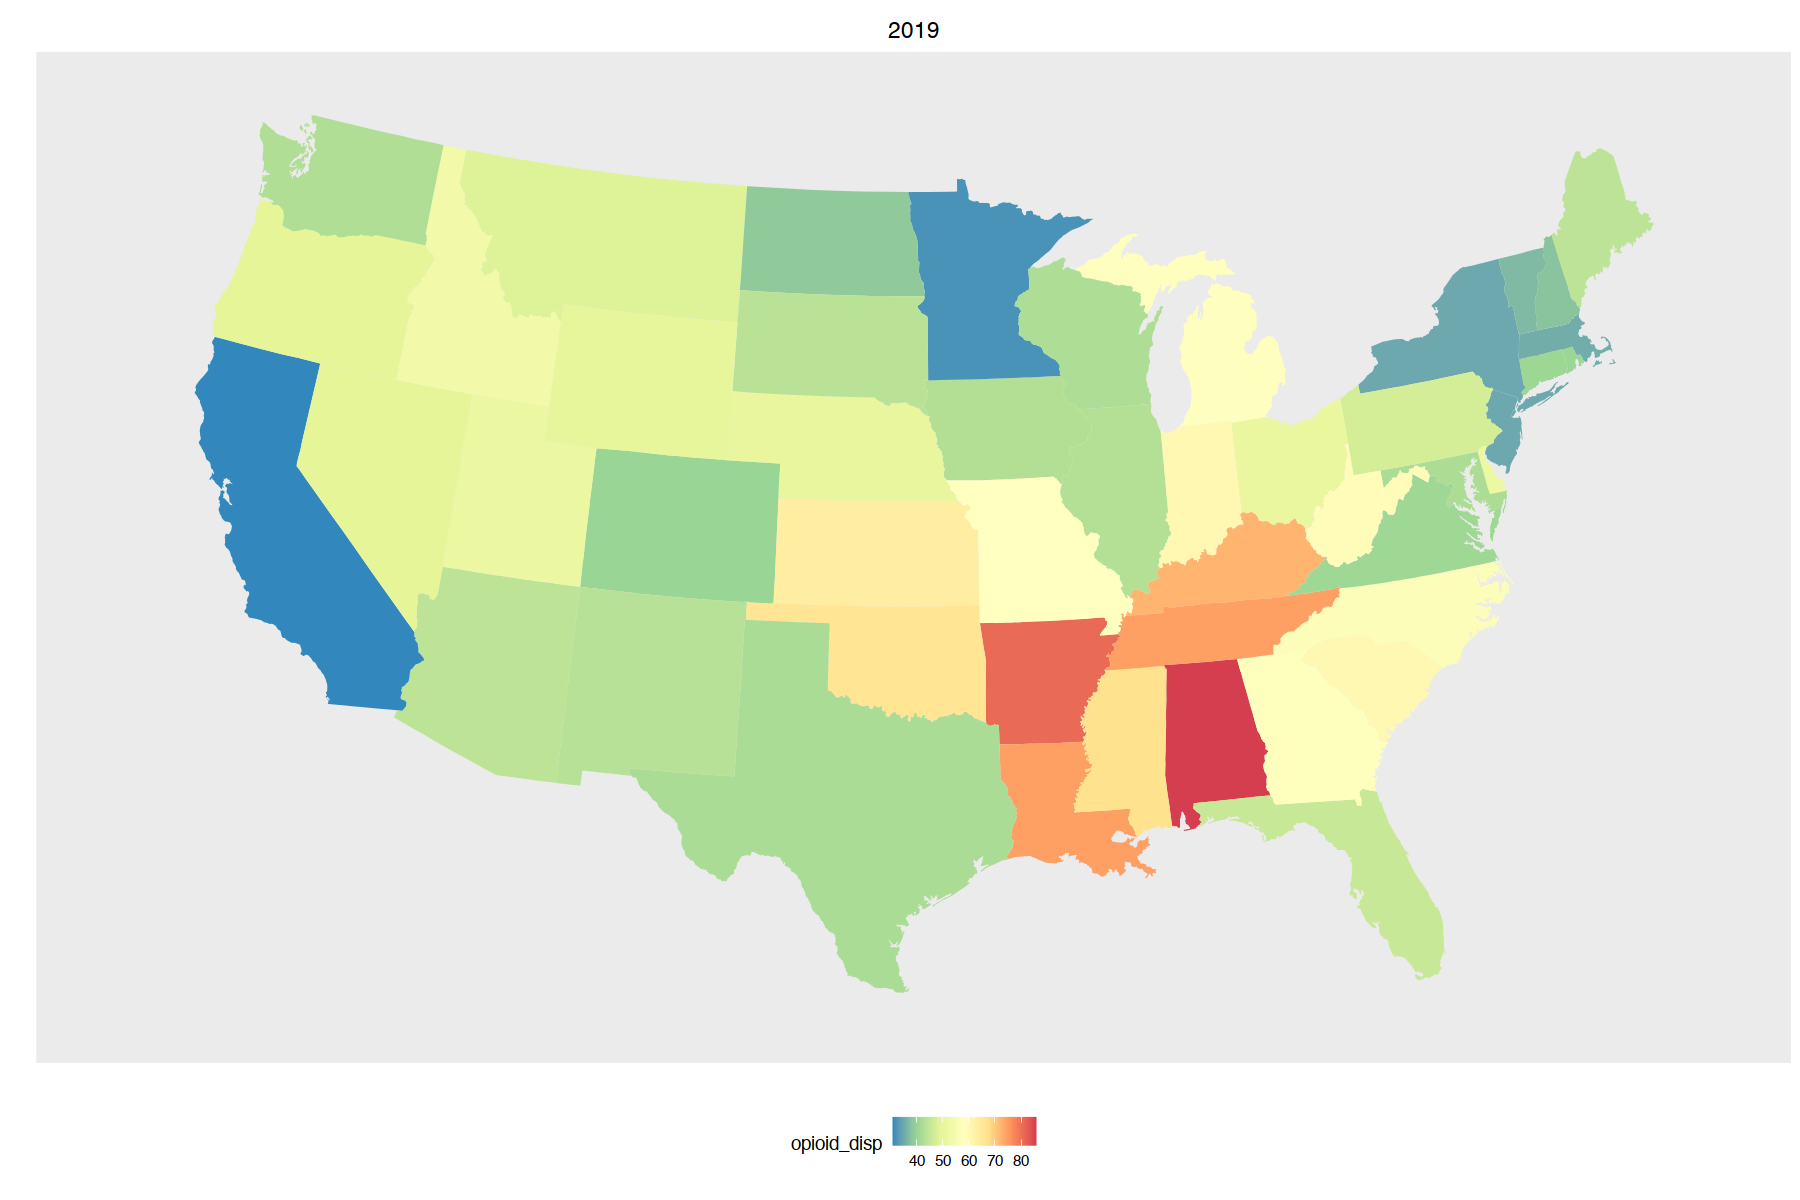

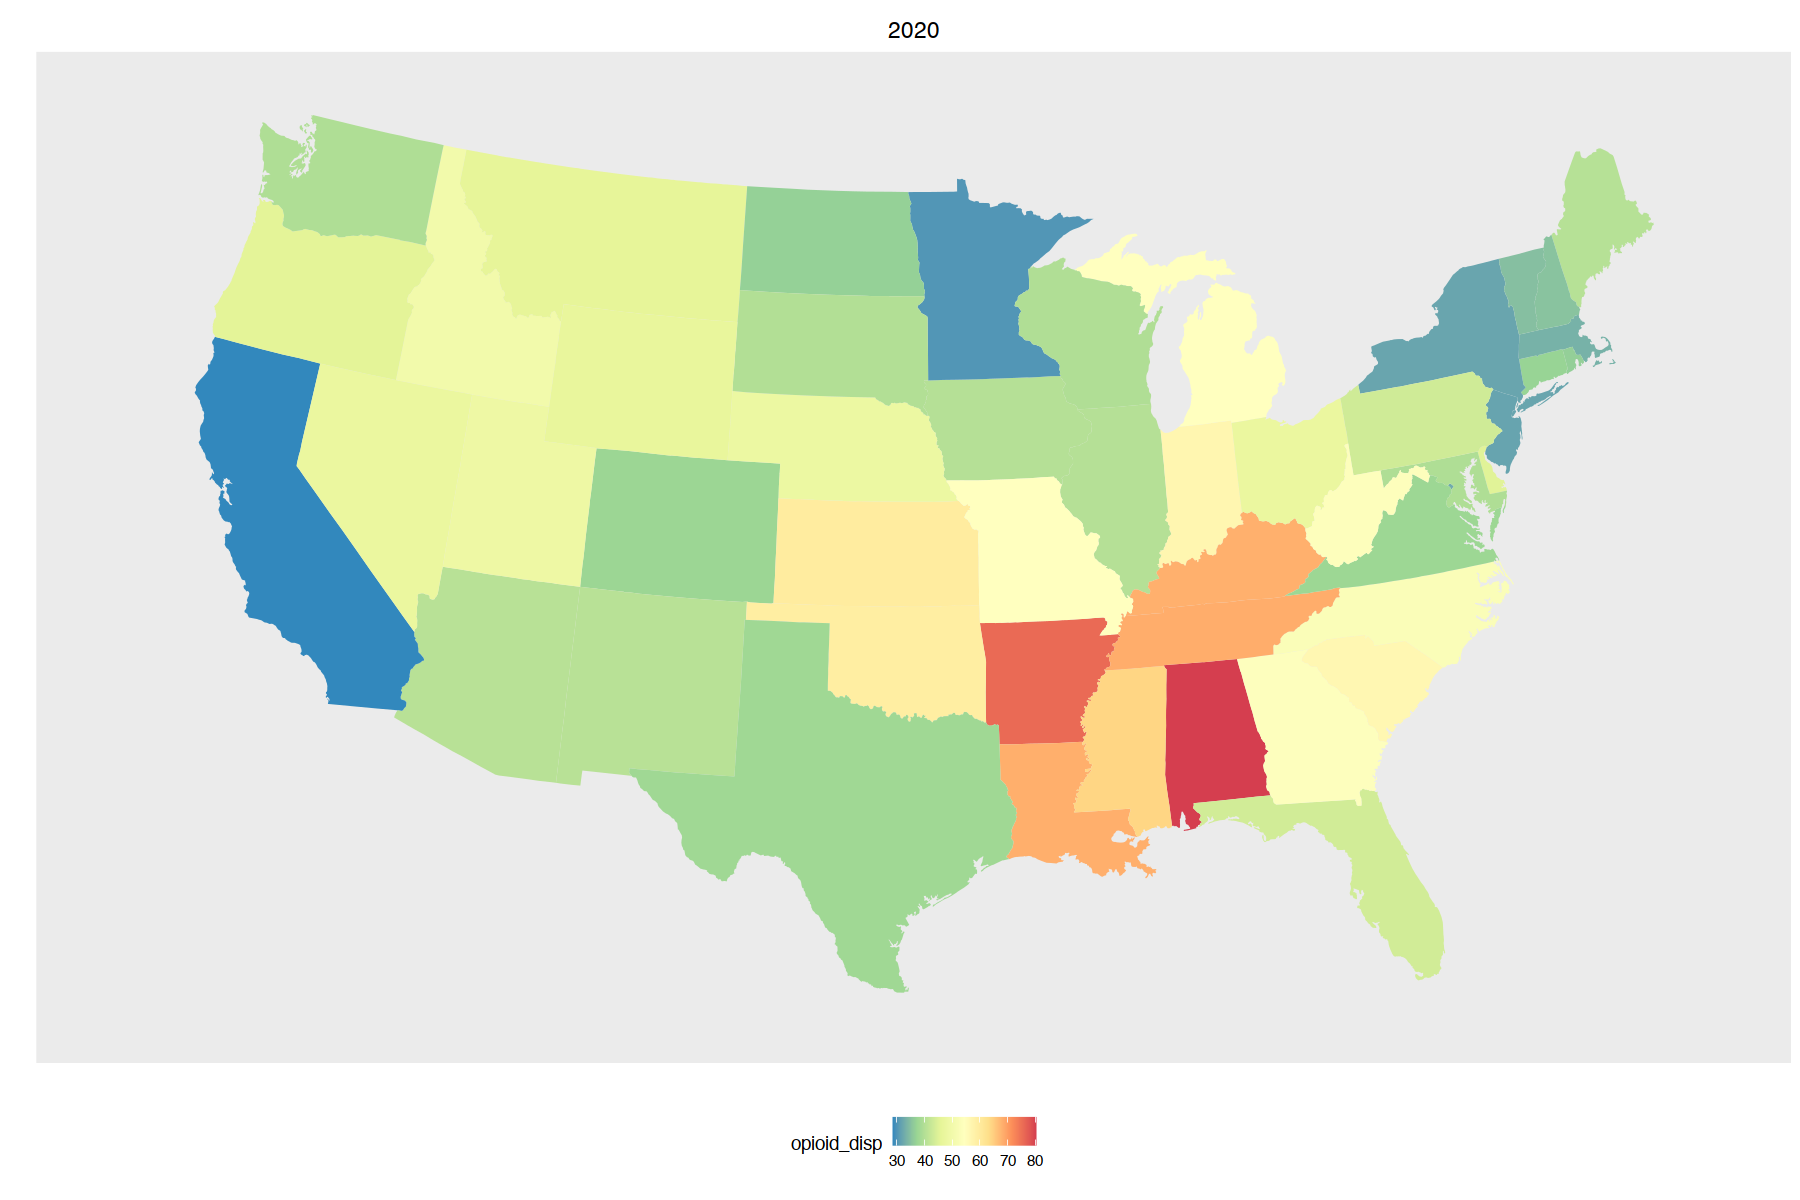

In [87]:
g <- ggplot(aes(x=long, y=lat, group = group, fill = opioid_disp), data = plotDat)+ 
  coord_map(projection = "albers", lat0 = 30, lat1 = 40, # the albers projection requires extra parameters 
            xlim = c(-122, -72)) +
  scale_fill_distiller(palette = "Spectral") + 
  xlab("") + ylab("") +
  theme(plot.title = element_text(hjust = 0.5),
        panel.border = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(),
        axis.text = element_blank(),
        axis.ticks = element_blank(),
        legend.position = "bottom",
  )

for (y in 2006:2020){
    
    gy <- g + geom_polygon(data = plotDat %>% filter(year == y)) +
            ggtitle(y) # adding a title
    
    print(gy)
    png(paste0("../figures/disp_rate_map", y, ".png"), width = 6, height = 4, units = 'in', res = 300)
        print(gy)
    dev.off()
    
}

### Exploring related variables

In [88]:
colnames(dat)

[1] "stateName"       "stateFIPS"       "year"            "mort"           
 [5] "pop"             "pctUrban_2010"   "vetPop_2020"     "mdcrEnr_2019"   
 [9] "mdcaidElig_2012" "medIncome_2019"  "pctPovty_2019"   "snap_2018"      
[13] "pctNoIns_2019"   "unplmtRate_2020" "popDens_2010"    "stateAbr"       
[17] "opioid_disp"     "rate"

Medicaid eligibility

In [ ]:
ggplot(aes(x = mdcaidElig_2012/pop, y = rate), 
       data = dat %>% filter(mdcaidElig_2012/pop < .05)) +
    geom_point() +
    facet_wrap(~year)

Urbanicity

In [ ]:
ggplot(aes(x = pctUrban_2010, y = rate), data = dat) +
    geom_point() +
    facet_wrap(~year)

% below poverty line

In [ ]:
ggplot(aes(x = pctPovty_2019, y = rate), data = dat) +
    geom_point() +
    facet_wrap(~year)

In [ ]:
dat %>%
    group_by(year) %>%
    summarize(cor = cor(pctPovty_2019, rate)) %>%
    ggplot(aes(x = year, y = cor)) +
    geom_line()

In [ ]:
ggplot(aes(x = pctPovty_2019, y = rate), data = dat %>% filter(year == 1999)) +
    geom_point()

Dispensing rate

In [ ]:
ggplot(aes(x = opioid_disp, y = rate), data = dat %>% filter(year > 2005)) +
    geom_point() +
    facet_wrap(~year)

In [ ]:
ggplot(aes(x = opioid_disp, y = rate), data = dat %>% filter(year == 2007)) +
    geom_point()

**Exercise:** Create a couple of plots to explore the potential relationships between overdose mortality rate and the covariates

In [ ]:
## YOUR CODE HERE ##